In [1]:
import numpy as np
import math, cv2, os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Activation, Dense, Conv2D, Reshape, concatenate, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.callbacks import LearningRateScheduler
from keras import optimizers
from IPython.display import clear_output
%matplotlib inline
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from random import randint
from sklearn.utils import shuffle
import tensorflow as tf

print(tf.__version__)

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

1.14.0


/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

In [2]:
train_dataset_path = "./dataset/TRAIN"
test_dataset_path = "./dataset/TEST"
pred_dataset_path = "./dataset/TEST_SIMPLE"

IMG_SIZE      = 128
data_list     = os.listdir(train_dataset_path)
NUM_CLASSES   = len(data_list)
BATCH_SIZE    = 32  
EPOCHS        = 25
CATEGORIES    = ['EOSINOPHIL','LYMPHOCYTE','MONOCYTE','NEUTROPHIL']

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
pred_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dataset_path,
        target_size=(IMG_SIZE, IMG_SIZE),
        color_mode='rgb',
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=None,
        class_mode="categorical")

test_generator = test_datagen.flow_from_directory(
        test_dataset_path,
        target_size=(IMG_SIZE, IMG_SIZE),
        color_mode='rgb',
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=None,
        class_mode="categorical")

Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


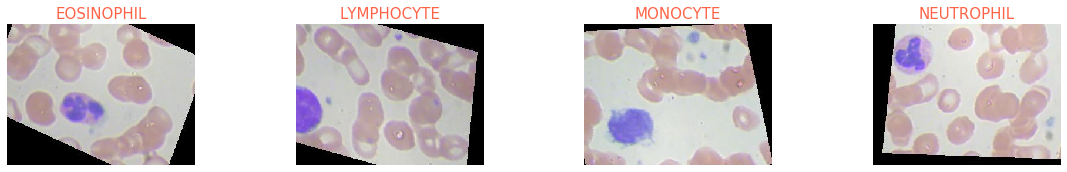

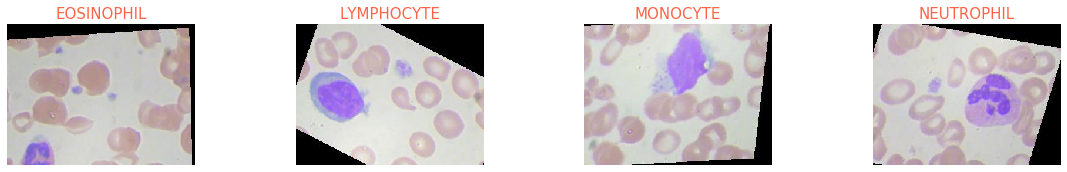

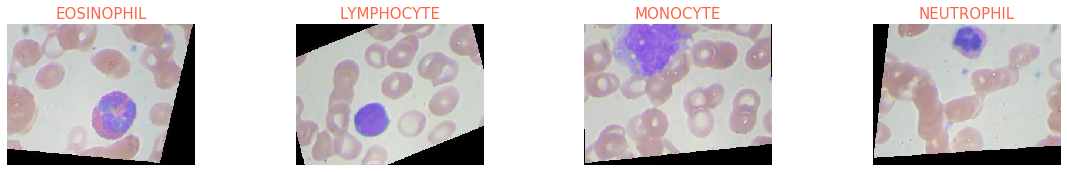

In [3]:
for k in range(3):
    i=0
    plt.figure(figsize=(25,15))
    for category in CATEGORIES:
        plt.subplot(5, 5, i+1)
        plt.yticks([])
        plt.xticks([])
        path=train_dataset_path + '/' + category
        image_p=os.listdir(path)
        plt.title(category , color='tomato').set_size(15)
        plt.axis('off')
        image = cv2.imread(os.path.join(path, image_p[k])) 
        image = image[:, :, [2, 1, 0]] 
        plt.imshow(image)
        i+=1

In [4]:
def lr_decay(epoch):
  return 0.01 * math.pow(0.666, epoch)
callback_learning_rate = LearningRateScheduler(lr_decay, verbose=True)

callback_is_nan = tf.keras.callbacks.TerminateOnNaN()

class PlotLosses(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [5]:
bnmomemtum=0.85
def fire(x, squeeze, expand):
  y  = Conv2D(filters=squeeze, kernel_size=1, activation='relu', padding='same')(x)
  y  = BatchNormalization(momentum=bnmomemtum)(y)
  y1 = Conv2D(filters=expand//2, kernel_size=1, activation='relu', padding='same')(y)
  y1 = BatchNormalization(momentum=bnmomemtum)(y1)
  y3 = Conv2D(filters=expand//2, kernel_size=3, activation='relu', padding='same')(y)
  y3 = BatchNormalization(momentum=bnmomemtum)(y3)
  return concatenate([y1, y3])

def fire_module(squeeze, expand):
  return lambda x: fire(x, squeeze, expand)

x = Input(shape=[IMG_SIZE, IMG_SIZE, 3])
y = BatchNormalization(center=True, scale=False)(x)
y = Activation('relu')(y)
y = Conv2D(kernel_size=5, filters=12, padding='same', use_bias=True, activation='relu')(x)
y = BatchNormalization(momentum=bnmomemtum)(y)

y = fire_module(12, 24)(y)
y = MaxPooling2D(pool_size=2)(y)

y = fire_module(24, 48)(y)
y = MaxPooling2D(pool_size=2)(y)

y = fire_module(32, 64)(y)
y = MaxPooling2D(pool_size=2)(y)

y = fire_module(24, 48)(y)
y = MaxPooling2D(pool_size=2)(y)

y = fire_module(18, 36)(y)
y = MaxPooling2D(pool_size=2)(y)

y = fire_module(12, 24)(y)

y = GlobalAveragePooling2D()(y)
y = Dense(NUM_CLASSES, activation='sigmoid')(y)
model = Model(x, y)
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 12) 912         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 128, 128, 12) 48          conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 12) 156         batch_normalization_2[0][0]      
__________________________________________________________________________________________________
batch_norm

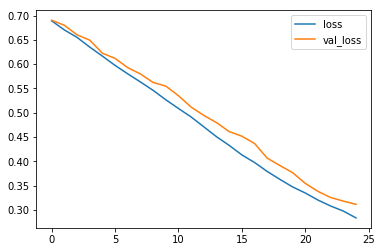

In [6]:
STEP_SIZE_TRAIN=train_generator.n // train_generator.batch_size 
STEP_SIZE_VALID=test_generator.n // test_generator.batch_size
history = model.fit_generator(
      train_generator,
      steps_per_epoch=STEP_SIZE_TRAIN, 
      epochs=EPOCHS,
      validation_data=test_generator,
      validation_steps=STEP_SIZE_VALID,
      callbacks=[plot_losses, callback_is_nan]) # callback_learning_rate,

In [7]:
accuracy = history.history['acc']
loss = history.history['loss']
val_accuracy = history.history['val_acc']
val_loss = history.history['val_loss']

print(f'Training Accuracy: {np.max(accuracy)}')
print(f'Training Loss: {np.min(loss)}')
print(f'Validation Accuracy: {np.max(val_accuracy)}')
print(f'Validation Loss: {np.min(val_loss)}')

Training Accuracy: 0.9270780856423174
Training Loss: 0.2834323223802245
Validation Accuracy: 0.9019348270538625
Validation Loss: 0.31142318813232683


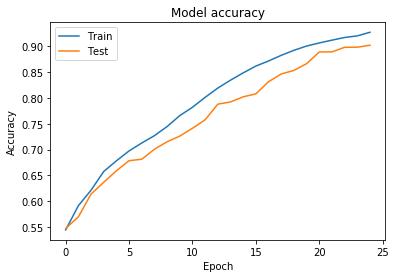

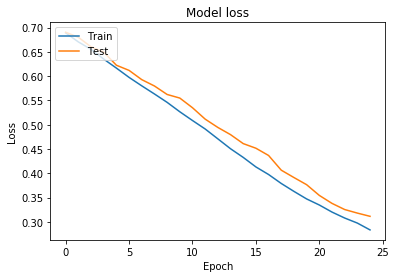

In [8]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [9]:
def get_images(directory):
    Images = []
    for categories in CATEGORIES:
        all_image_paths=os.listdir(pred_dataset_path+'/'+categories)
        for image_file in all_image_paths:
            image=cv2.imread(directory+'/'+categories+'/'+image_file)
            image=cv2.resize(image,(IMG_SIZE, IMG_SIZE))
            Images.append(image)

    return shuffle(Images,random_state=81732)

pred_images = get_images(pred_dataset_path)
pred_images = np.array(pred_images)
pred_images.shape

(71, 128, 128, 3)

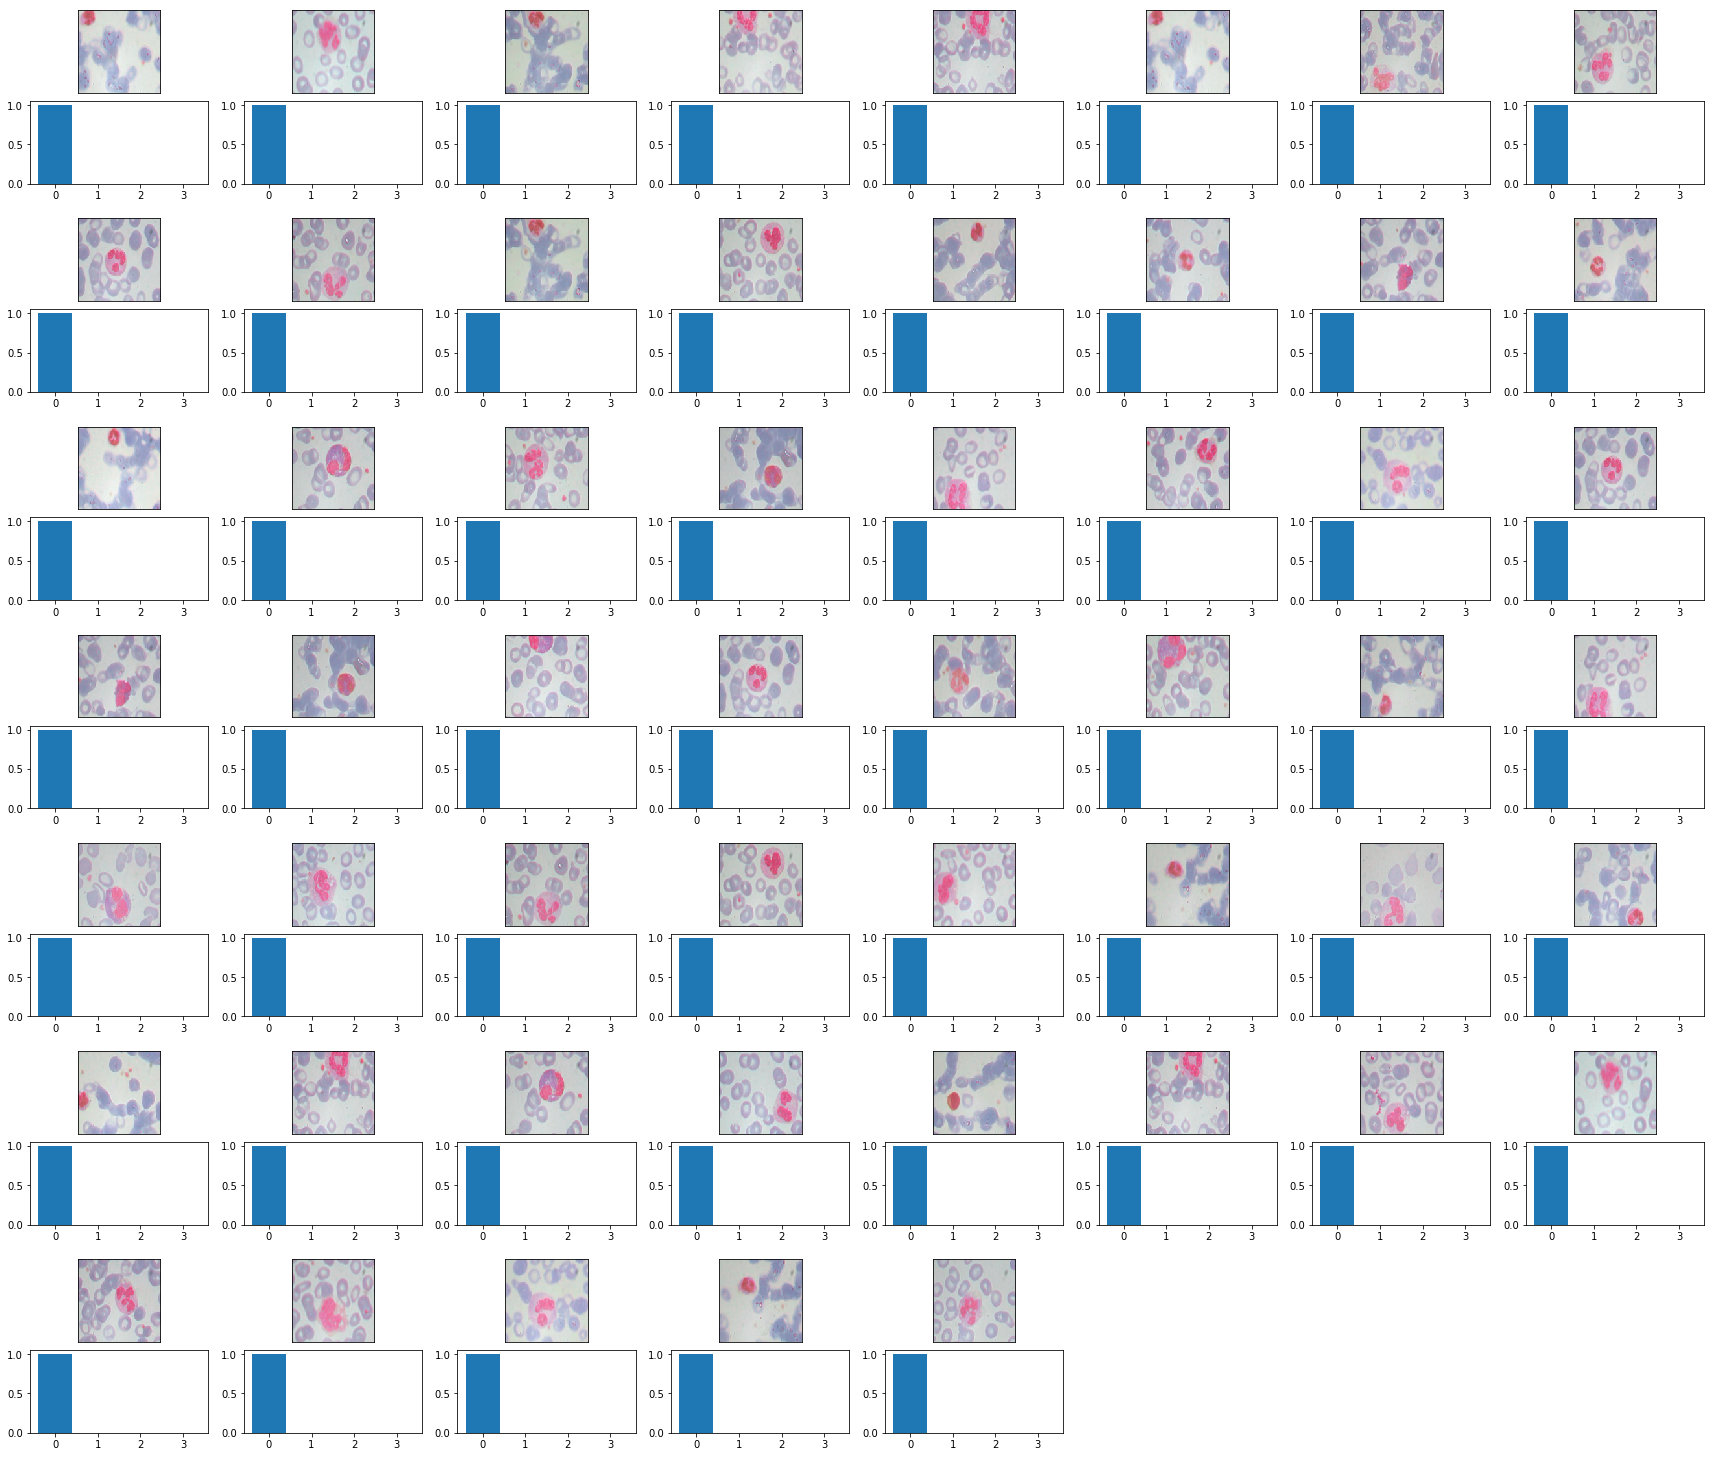

In [10]:
fig = plt.figure(figsize=(30, 30))
outer = gridspec.GridSpec(8, 8, wspace=0.2, hspace=0.2)

for i in range(53):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,subplot_spec=outer[i], wspace=0.1, hspace=0.1)
    rnd_number = randint(0,len(pred_images))
    pred_image = np.array([pred_images[rnd_number]])
    pred_prob = model.predict(pred_image).reshape(4)
    for j in range(2):
        if (j%2) == 0:
            ax = plt.Subplot(fig, inner[j])
            ax.imshow(pred_image[0])
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)
        else:
            ax = plt.Subplot(fig, inner[j])
            ax.bar([0,1,2,3], pred_prob)
            fig.add_subplot(ax)

fig.show()